# JupyterLite で学ぶ pandas 中級チュートリアル

このノートブックは、**JupyterLite（ブラウザだけで動く Jupyter 環境）** 上で、
pandas の中級レベルの機能を学ぶためのチュートリアルです。

## 対象者
- pandas の基礎（Series, DataFrame の作成、選択、フィルタリング）を理解している方
- より実践的なデータ操作を学びたい方

## このチュートリアルで学ぶこと
1. groupby による集計
2. 欠損値（NaN）の処理
3. データの結合（merge, concat, join）
4. データの変換（apply, map, transform）
5. ピボットテーブルとクロス集計
6. 時系列データの処理
7. 文字列操作
8. カテゴリカルデータの扱い

## 0. 環境準備（JupyterLite 用）

まず、必要なライブラリをインストールします。

In [1]:
try:
    import piplite
    await piplite.install(["numpy", "pandas", "matplotlib", "seaborn", "japanize-matplotlib-jlite"])
except ImportError:
    pass

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib_jlite

pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 10)
np.random.seed(42)

print(f"pandas バージョン: {pd.__version__}")

pandas バージョン: 2.3.3


### サンプルデータの作成

このチュートリアルで使用するサンプルデータを作成します。

In [3]:
# 売上データ
np.random.seed(42)
n_records = 100

sales_df = pd.DataFrame({
    "日付": pd.date_range("2024-01-01", periods=n_records, freq="D"),
    "店舗": np.random.choice(["東京", "大阪", "名古屋", "福岡"], n_records),
    "カテゴリ": np.random.choice(["食品", "飲料", "日用品", "衣類"], n_records),
    "売上": np.random.randint(10000, 100000, n_records),
    "客数": np.random.randint(50, 300, n_records)
})

# 欠損値を意図的に追加
sales_df.loc[np.random.choice(sales_df.index, 10), "売上"] = np.nan
sales_df.loc[np.random.choice(sales_df.index, 5), "客数"] = np.nan

print("売上データ（sales_df）:")
sales_df.head(10)

売上データ（sales_df）:


,日付,店舗,カテゴリ,売上,客数
0,2024-01-01,名古屋,日用品,60015.0,88.0
1,2024-01-02,福岡,飲料,64268.0,131.0
2,2024-01-03,東京,飲料,97939.0,153.0
3,2024-01-04,名古屋,衣類,28141.0,NaN
4,2024-01-05,名古屋,飲料,90356.0,60.0
5,2024-01-06,福岡,飲料,81910.0,269.0
6,2024-01-07,東京,飲料,66044.0,234.0
7,2024-01-08,東京,衣類,77214.0,266.0
8,2024-01-09,名古屋,飲料,43827.0,227.0
9,2024-01-10,大阪,日用品,65820.0,200.0


In [4]:
# 顧客マスタ
customers_df = pd.DataFrame({
    "顧客ID": ["C001", "C002", "C003", "C004", "C005"],
    "氏名": ["田中太郎", "佐藤花子", "鈴木一郎", "高橋美咲", "伊藤健太"],
    "年齢": [28, 35, 42, 23, 31],
    "会員ランク": ["Gold", "Silver", "Gold", "Bronze", "Silver"]
})

# 購入履歴
orders_df = pd.DataFrame({
    "注文ID": ["O001", "O002", "O003", "O004", "O005", "O006", "O007"],
    "顧客ID": ["C001", "C002", "C001", "C003", "C002", "C004", "C006"],  # C006 は存在しない
    "金額": [5000, 3000, 8000, 12000, 4500, 2000, 6000],
    "購入日": pd.to_datetime(["2024-01-05", "2024-01-10", "2024-01-15", 
                             "2024-01-20", "2024-01-25", "2024-02-01", "2024-02-05"])
})

print("顧客マスタ（customers_df）:")
print(customers_df)
print("\n購入履歴（orders_df）:")
print(orders_df)

顧客マスタ（customers_df）:
   顧客ID    氏名  年齢   会員ランク
0  C001  田中太郎  28    Gold
1  C002  佐藤花子  35  Silver
2  C003  鈴木一郎  42    Gold
3  C004  高橋美咲  23  Bronze
4  C005  伊藤健太  31  Silver

購入履歴（orders_df）:
   注文ID  顧客ID     金額        購入日
0  O001  C001   5000 2024-01-05
1  O002  C002   3000 2024-01-10
2  O003  C001   8000 2024-01-15
3  O004  C003  12000 2024-01-20
4  O005  C002   4500 2024-01-25
5  O006  C004   2000 2024-02-01
6  O007  C006   6000 2024-02-05


---
## 1. groupby による集計

`groupby` は、データをグループ化して集計するための強力な機能です。
SQL の GROUP BY と同様の操作が可能です。

### 1.1 基本的な groupby

In [5]:
# 店舗ごとの売上合計
sales_df.groupby("店舗")["売上"].sum()

店舗
名古屋    1402802.0
大阪     1412916.0
東京     1026794.0
福岡     1454158.0
Name: 売上, dtype: float64

In [6]:
# 店舗ごとの売上平均と客数平均
sales_df.groupby("店舗")[["売上", "客数"]].mean()

,売上,客数
店舗,,
名古屋,63763.727273,182.521739
大阪,61431.130435,162.291667
東京,54041.789474,180.263158
福岡,53857.703704,183.758621


### 1.2 複数キーでの groupby

In [7]:
# 店舗 × カテゴリ ごとの売上合計
sales_df.groupby(["店舗", "カテゴリ"])["売上"].sum()

店舗   カテゴリ
名古屋  日用品     201102.0
     衣類      199962.0
     食品      778539.0
     飲料      223199.0
大阪   日用品     244780.0
               ...   
東京   飲料      276339.0
福岡   日用品     738682.0
     衣類      233824.0
     食品      176920.0
     飲料      304732.0
Name: 売上, Length: 16, dtype: float64

In [8]:
# unstack で見やすい表形式に
sales_df.groupby(["店舗", "カテゴリ"])["売上"].sum().unstack(fill_value=0)

カテゴリ,日用品,衣類,食品,飲料
店舗,,,,
名古屋,201102.0,199962.0,778539.0,223199.0
大阪,244780.0,284689.0,407422.0,476025.0
東京,232062.0,286319.0,232074.0,276339.0
福岡,738682.0,233824.0,176920.0,304732.0


### 1.3 agg で複数の集計関数を適用

In [9]:
# 店舗ごとに複数の統計量を計算
sales_df.groupby("店舗")["売上"].agg(["sum", "mean", "std", "count"])

,sum,mean,std,count
店舗,,,,
名古屋,1402802.0,63763.727273,28381.893846,22
大阪,1412916.0,61431.130435,25328.138225,23
東京,1026794.0,54041.789474,22479.852925,19
福岡,1454158.0,53857.703704,23292.681193,27


In [10]:
# 列ごとに異なる集計関数を適用
sales_df.groupby("店舗").agg({
    "売上": ["sum", "mean"],
    "客数": ["sum", "max"]
})

売上                    客数       
           sum          mean     sum    max
店舗                                         
名古屋  1402802.0  63763.727273  4198.0  293.0
大阪   1412916.0  61431.130435  3895.0  297.0
東京   1026794.0  54041.789474  3425.0  282.0
福岡   1454158.0  53857.703704  5329.0  296.0

### 1.4 名前付き集計（pandas 0.25+）

In [11]:
# 集計結果の列名を指定
sales_df.groupby("店舗").agg(
    売上合計=("売上", "sum"),
    売上平均=("売上", "mean"),
    客数合計=("客数", "sum"),
    件数=("売上", "count")
)

,売上合計,売上平均,客数合計,件数
店舗,,,,
名古屋,1402802.0,63763.727273,4198.0,22
大阪,1412916.0,61431.130435,3895.0,23
東京,1026794.0,54041.789474,3425.0,19
福岡,1454158.0,53857.703704,5329.0,27


### 1.5 groupby + transform

`transform` は、グループごとの計算結果を元の行数で返します。

In [12]:
# 店舗ごとの売上平均を各行に追加
sales_df["店舗売上平均"] = sales_df.groupby("店舗")["売上"].transform("mean")

# 店舗平均との差を計算
sales_df["売上差分"] = sales_df["売上"] - sales_df["店舗売上平均"]

sales_df[["店舗", "売上", "店舗売上平均", "売上差分"]].head(10)

,店舗,売上,店舗売上平均,売上差分
0,名古屋,60015.0,63763.727273,-3748.727273
1,福岡,64268.0,53857.703704,10410.296296
2,東京,97939.0,54041.789474,43897.210526
3,名古屋,28141.0,63763.727273,-35622.727273
4,名古屋,90356.0,63763.727273,26592.272727
5,福岡,81910.0,53857.703704,28052.296296
6,東京,66044.0,54041.789474,12002.210526
7,東京,77214.0,54041.789474,23172.210526
8,名古屋,43827.0,63763.727273,-19936.727273
9,大阪,65820.0,61431.130435,4388.869565


### 📝 1章 練習問題

1. カテゴリごとの売上合計と平均を計算しなさい。
2. 店舗 × カテゴリ ごとの客数の合計を、見やすい表形式で表示しなさい。
3. 店舗ごとの売上の最大値、最小値、レンジ（最大-最小）を計算しなさい。
4. `transform` を使って、各行にカテゴリごとの売上合計を追加し、その売上が全体の何%かを計算しなさい。

In [13]:
# 練習問題の解答欄



---
## 2. 欠損値（NaN）の処理

実際のデータには欠損値が含まれることが多いです。
欠損値の確認、削除、補完の方法を学びます。

### 2.1 欠損値の確認

In [14]:
# 欠損値の有無を確認
print("欠損値の有無:")
print(sales_df.isna().any())

print("\n列ごとの欠損数:")
print(sales_df.isna().sum())

print(f"\n全体の欠損数: {sales_df.isna().sum().sum()}")

欠損値の有無:
日付        False
店舗        False
カテゴリ      False
売上         True
客数         True
店舗売上平均    False
売上差分       True
dtype: bool

列ごとの欠損数:
日付        0
店舗        0
カテゴリ      0
売上        9
客数        5
店舗売上平均    0
売上差分      9
dtype: int64

全体の欠損数: 23


In [15]:
# 欠損値のある行を確認
print("欠損値のある行:")
sales_df[sales_df.isna().any(axis=1)]

欠損値のある行:


,日付,店舗,カテゴリ,売上,客数,店舗売上平均,売上差分
3,2024-01-04,名古屋,衣類,28141.0,NaN,63763.727273,-35622.727273
18,2024-01-19,福岡,衣類,12693.0,NaN,53857.703704,-41164.703704
20,2024-01-21,大阪,衣類,NaN,109.0,61431.130435,NaN
27,2024-01-28,大阪,食品,NaN,86.0,61431.130435,NaN
29,2024-01-30,福岡,衣類,NaN,296.0,53857.703704,NaN
34,2024-02-04,大阪,日用品,16776.0,NaN,61431.130435,-44655.130435
47,2024-02-17,名古屋,日用品,NaN,213.0,63763.727273,NaN
48,2024-02-18,大阪,食品,61005.0,NaN,61431.130435,-426.130435
60,2024-03-01,名古屋,日用品,NaN,131.0,63763.727273,NaN
63,2024-03-04,東京,衣類,NaN,NaN,54041.789474,NaN


### 2.2 欠損値の削除

In [16]:
# 欠損値のある行を削除
df_dropped = sales_df.dropna()
print(f"元の行数: {len(sales_df)}, 削除後: {len(df_dropped)}")

元の行数: 100, 削除後: 87


In [17]:
# 特定の列に欠損がある行のみ削除
df_dropped_sales = sales_df.dropna(subset=["売上"])
print(f"売上の欠損行を削除: {len(df_dropped_sales)}")

売上の欠損行を削除: 91


### 2.3 欠損値の補完

In [18]:
# 固定値で補完
df_filled_0 = sales_df.copy()
df_filled_0["売上"] = df_filled_0["売上"].fillna(0)
print("0 で補完後の欠損数:", df_filled_0["売上"].isna().sum())

0 で補完後の欠損数: 0


In [19]:
# 平均値で補完
df_filled_mean = sales_df.copy()
mean_value = df_filled_mean["売上"].mean()
df_filled_mean["売上"] = df_filled_mean["売上"].fillna(mean_value)
print(f"平均値 ({mean_value:.0f}) で補完")

平均値 (58205) で補完


In [20]:
# グループごとの平均で補完（より適切な方法）
df_filled_group = sales_df.copy()
df_filled_group["売上"] = df_filled_group.groupby("店舗")["売上"].transform(
    lambda x: x.fillna(x.mean())
)
print("店舗ごとの平均で補完後の欠損数:", df_filled_group["売上"].isna().sum())

店舗ごとの平均で補完後の欠損数: 0


In [21]:
# 前の値で補完（時系列データに有効）
df_ffill = sales_df.copy()
df_ffill["売上"] = df_ffill["売上"].ffill()  # forward fill

# 後の値で補完
df_bfill = sales_df.copy()
df_bfill["売上"] = df_bfill["売上"].bfill()  # backward fill

print("前の値で補完後の欠損数:", df_ffill["売上"].isna().sum())

前の値で補完後の欠損数: 0


### 2.4 補間（interpolate）

In [22]:
# 線形補間
df_interp = sales_df.copy()
df_interp["売上"] = df_interp["売上"].interpolate(method="linear")
print("線形補間後の欠損数:", df_interp["売上"].isna().sum())

線形補間後の欠損数: 0


### 📝 2章 練習問題

1. `sales_df` の「客数」列の欠損値を、カテゴリごとの中央値で補完しなさい。
2. 欠損値を補完する方法（削除、固定値、平均、グループ平均、補間など）について、それぞれの長所と短所を説明しなさい。
3. 欠損値の割合が高い場合（例：30%以上）、どのような対処法が考えられるか説明しなさい。

In [23]:
# 練習問題の解答欄



---
## 3. データの結合（merge, concat, join）

複数のテーブルを組み合わせる方法を学びます。

### 3.1 merge（キーに基づく結合）

SQL の JOIN と同様の操作です。

In [24]:
# inner join（両方に存在するキーのみ）
merged_inner = pd.merge(orders_df, customers_df, on="顧客ID", how="inner")
print("inner join:")
merged_inner

inner join:


,注文ID,顧客ID,金額,購入日,氏名,年齢,会員ランク
0,O001,C001,5000,2024-01-05,田中太郎,28,Gold
1,O002,C002,3000,2024-01-10,佐藤花子,35,Silver
2,O003,C001,8000,2024-01-15,田中太郎,28,Gold
3,O004,C003,12000,2024-01-20,鈴木一郎,42,Gold
4,O005,C002,4500,2024-01-25,佐藤花子,35,Silver
5,O006,C004,2000,2024-02-01,高橋美咲,23,Bronze


In [25]:
# left join（左のテーブルを基準）
merged_left = pd.merge(orders_df, customers_df, on="顧客ID", how="left")
print("left join（C006 は顧客マスタにないので NaN）:")
merged_left

left join（C006 は顧客マスタにないので NaN）:


,注文ID,顧客ID,金額,購入日,氏名,年齢,会員ランク
0,O001,C001,5000,2024-01-05,田中太郎,28.0,Gold
1,O002,C002,3000,2024-01-10,佐藤花子,35.0,Silver
2,O003,C001,8000,2024-01-15,田中太郎,28.0,Gold
3,O004,C003,12000,2024-01-20,鈴木一郎,42.0,Gold
4,O005,C002,4500,2024-01-25,佐藤花子,35.0,Silver
5,O006,C004,2000,2024-02-01,高橋美咲,23.0,Bronze
6,O007,C006,6000,2024-02-05,NaN,NaN,NaN


In [26]:
# right join（右のテーブルを基準）
merged_right = pd.merge(orders_df, customers_df, on="顧客ID", how="right")
print("right join（C005 は注文がないので NaN）:")
merged_right

right join（C005 は注文がないので NaN）:


,注文ID,顧客ID,金額,購入日,氏名,年齢,会員ランク
0,O001,C001,5000.0,2024-01-05,田中太郎,28,Gold
1,O003,C001,8000.0,2024-01-15,田中太郎,28,Gold
2,O002,C002,3000.0,2024-01-10,佐藤花子,35,Silver
3,O005,C002,4500.0,2024-01-25,佐藤花子,35,Silver
4,O004,C003,12000.0,2024-01-20,鈴木一郎,42,Gold
5,O006,C004,2000.0,2024-02-01,高橋美咲,23,Bronze
6,NaN,C005,NaN,NaT,伊藤健太,31,Silver


In [27]:
# outer join（両方のすべてのキー）
merged_outer = pd.merge(orders_df, customers_df, on="顧客ID", how="outer")
print("outer join:")
merged_outer

outer join:


,注文ID,顧客ID,金額,購入日,氏名,年齢,会員ランク
0,O001,C001,5000.0,2024-01-05,田中太郎,28.0,Gold
1,O003,C001,8000.0,2024-01-15,田中太郎,28.0,Gold
2,O002,C002,3000.0,2024-01-10,佐藤花子,35.0,Silver
3,O005,C002,4500.0,2024-01-25,佐藤花子,35.0,Silver
4,O004,C003,12000.0,2024-01-20,鈴木一郎,42.0,Gold
5,O006,C004,2000.0,2024-02-01,高橋美咲,23.0,Bronze
6,NaN,C005,NaN,NaT,伊藤健太,31.0,Silver
7,O007,C006,6000.0,2024-02-05,NaN,NaN,NaN


### 3.2 異なる列名での結合

In [28]:
# 列名が異なる場合
customers_df2 = customers_df.rename(columns={"顧客ID": "ID"})

merged_diff = pd.merge(
    orders_df, 
    customers_df2, 
    left_on="顧客ID", 
    right_on="ID", 
    how="inner"
)
merged_diff

,注文ID,顧客ID,金額,購入日,ID,氏名,年齢,会員ランク
0,O001,C001,5000,2024-01-05,C001,田中太郎,28,Gold
1,O002,C002,3000,2024-01-10,C002,佐藤花子,35,Silver
2,O003,C001,8000,2024-01-15,C001,田中太郎,28,Gold
3,O004,C003,12000,2024-01-20,C003,鈴木一郎,42,Gold
4,O005,C002,4500,2024-01-25,C002,佐藤花子,35,Silver
5,O006,C004,2000,2024-02-01,C004,高橋美咲,23,Bronze


### 3.3 concat（単純な連結）

In [29]:
# 行方向の連結（縦に積み重ねる）
df1 = pd.DataFrame({"A": [1, 2], "B": [3, 4]})
df2 = pd.DataFrame({"A": [5, 6], "B": [7, 8]})

concatenated = pd.concat([df1, df2], ignore_index=True)
print("行方向の連結:")
concatenated

行方向の連結:


,A,B
0,1,3
1,2,4
2,5,7
3,6,8


In [30]:
# 列方向の連結（横に並べる）
df3 = pd.DataFrame({"C": [10, 20], "D": [30, 40]})

concatenated_cols = pd.concat([df1, df3], axis=1)
print("列方向の連結:")
concatenated_cols

列方向の連結:


,A,B,C,D
0,1,3,10,30
1,2,4,20,40


### 3.4 merge と concat の使い分け

| 操作 | 使用場面 | メソッド |
|-----|---------|--------|
| キーに基づく結合 | 顧客IDで紐づけるなど | `merge` |
| 単純な縦積み | 月別データの連結など | `concat(axis=0)` |
| 単純な横並び | 別々の列を追加など | `concat(axis=1)` |

### 📝 3章 練習問題

1. `orders_df` と `customers_df` を left join で結合し、会員ランクごとの購入金額の合計を計算しなさい。
2. 顧客マスタに存在しない顧客ID（C006）の注文を抽出しなさい。
3. 新しい注文データを作成し、`concat` で `orders_df` に追加しなさい。
4. inner join と left join の結果が異なる場合について、具体例を挙げて説明しなさい。

In [31]:
# 練習問題の解答欄



---
## 4. データの変換（apply, map, transform）

データを柔軟に変換するためのメソッドを学びます。

### 4.1 apply（関数を適用）

In [32]:
# Series に関数を適用
def categorize_sales(x):
    if pd.isna(x):
        return "不明"
    elif x >= 70000:
        return "高"
    elif x >= 40000:
        return "中"
    else:
        return "低"

sales_df["売上ランク"] = sales_df["売上"].apply(categorize_sales)
sales_df[["売上", "売上ランク"]].head(10)

,売上,売上ランク
0,60015.0,中
1,64268.0,中
2,97939.0,高
3,28141.0,低
4,90356.0,高
5,81910.0,高
6,66044.0,中
7,77214.0,高
8,43827.0,中
9,65820.0,中


In [33]:
# ラムダ式で簡潔に
sales_df["売上（万円）"] = sales_df["売上"].apply(lambda x: x / 10000 if pd.notna(x) else np.nan)
sales_df[["売上", "売上（万円）"]].head()

,売上,売上（万円）
0,60015.0,6.0015
1,64268.0,6.4268
2,97939.0,9.7939
3,28141.0,2.8141
4,90356.0,9.0356


In [34]:
# DataFrame の行に関数を適用
def calc_unit_sales(row):
    if pd.notna(row["売上"]) and pd.notna(row["客数"]) and row["客数"] > 0:
        return row["売上"] / row["客数"]
    return np.nan

sales_df["客単価"] = sales_df.apply(calc_unit_sales, axis=1)
sales_df[["売上", "客数", "客単価"]].head()

,売上,客数,客単価
0,60015.0,88.0,681.988636
1,64268.0,131.0,490.595420
2,97939.0,153.0,640.124183
3,28141.0,NaN,NaN
4,90356.0,60.0,1505.933333


### 4.2 map（値の置換）

In [35]:
# 辞書で値を置換
rank_map = {"高": 3, "中": 2, "低": 1, "不明": 0}
sales_df["売上ランク数値"] = sales_df["売上ランク"].map(rank_map)
sales_df[["売上ランク", "売上ランク数値"]].head()

,売上ランク,売上ランク数値
0,中,2
1,中,2
2,高,3
3,低,1
4,高,3


In [36]:
# replace でも同様のことができる
sales_df["店舗コード"] = sales_df["店舗"].replace({
    "東京": "TKY",
    "大阪": "OSK",
    "名古屋": "NGY",
    "福岡": "FKO"
})
sales_df[["店舗", "店舗コード"]].head()

,店舗,店舗コード
0,名古屋,NGY
1,福岡,FKO
2,東京,TKY
3,名古屋,NGY
4,名古屋,NGY


### 4.3 cut と qcut（ビニング）

In [37]:
# cut: 等間隔でビニング
sales_df["売上区分"] = pd.cut(
    sales_df["売上"],
    bins=[0, 30000, 60000, 100000],
    labels=["低", "中", "高"]
)
sales_df["売上区分"].value_counts()

売上区分
高    48
中    29
低    14
Name: count, dtype: int64

In [38]:
# qcut: データを等分（同じ件数ずつ）
sales_df["売上四分位"] = pd.qcut(
    sales_df["売上"].dropna(),
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)
sales_df["売上四分位"].value_counts()

売上四分位
Q1    23
Q2    23
Q4    23
Q3    22
Name: count, dtype: int64

### 📝 4章 練習問題

1. 客数を「少ない（100未満）」「普通（100以上200未満）」「多い（200以上）」の3段階に分類する関数を作り、`apply` で適用しなさい。
2. `map` を使って、カテゴリを英語表記に変換しなさい（食品→Food, 飲料→Beverage, 日用品→Daily, 衣類→Clothing）。
3. `qcut` を使って、客単価を5段階に分類しなさい。
4. `apply` と `map` の使い分けについて、自分の言葉で説明しなさい。

In [39]:
# 練習問題の解答欄



---
## 5. ピボットテーブルとクロス集計

Excel のピボットテーブルのような集計表を作成します。

### 5.1 pivot_table

In [40]:
# 店舗 × カテゴリ の売上合計
pivot = pd.pivot_table(
    sales_df,
    values="売上",
    index="店舗",
    columns="カテゴリ",
    aggfunc="sum",
    fill_value=0
)
pivot

カテゴリ,日用品,衣類,食品,飲料
店舗,,,,
名古屋,201102.0,199962.0,778539.0,223199.0
大阪,244780.0,284689.0,407422.0,476025.0
東京,232062.0,286319.0,232074.0,276339.0
福岡,738682.0,233824.0,176920.0,304732.0


In [41]:
# 合計行・列を追加
pivot_with_totals = pd.pivot_table(
    sales_df,
    values="売上",
    index="店舗",
    columns="カテゴリ",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    margins_name="合計"
)
pivot_with_totals

カテゴリ,日用品,衣類,食品,飲料,合計
店舗,,,,,
名古屋,201102.0,199962.0,778539.0,223199.0,1402802.0
大阪,244780.0,284689.0,407422.0,476025.0,1412916.0
東京,232062.0,286319.0,232074.0,276339.0,1026794.0
福岡,738682.0,233824.0,176920.0,304732.0,1454158.0
合計,1416626.0,1004794.0,1594955.0,1280295.0,5296670.0


In [42]:
# 複数の集計関数
pivot_multi = pd.pivot_table(
    sales_df,
    values="売上",
    index="店舗",
    columns="カテゴリ",
    aggfunc=["sum", "mean", "count"]
)
pivot_multi

sum                                   mean  ...                \
カテゴリ       日用品        衣類        食品        飲料      日用品  ...            飲料   
店舗                                                     ...                 
名古屋   201102.0  199962.0  778539.0  223199.0  67034.0  ...  55799.750000   
大阪    244780.0  284689.0  407422.0  476025.0  48956.0  ...  68003.571429   
東京    232062.0  286319.0  232074.0  276339.0  46412.4  ...  69084.750000   
福岡    738682.0  233824.0  176920.0  304732.0  52763.0  ...  76183.000000   

     count            
カテゴリ   日用品 衣類  食品 飲料  
店舗                    
名古屋      3  4  11  4  
大阪       5  5   6  7  
東京       5  6   4  4  
福岡      14  5   4  4  

[4 rows x 12 columns]

### 5.2 crosstab（クロス集計）

In [43]:
# 店舗 × カテゴリ の件数
cross = pd.crosstab(sales_df["店舗"], sales_df["カテゴリ"])
cross

カテゴリ,日用品,衣類,食品,飲料
店舗,,,,
名古屋,5,4,11,4
大阪,5,6,7,8
東京,5,7,4,4
福岡,15,7,4,4


In [44]:
# 割合（行方向）
cross_pct = pd.crosstab(
    sales_df["店舗"], 
    sales_df["カテゴリ"],
    normalize="index"  # "columns" or "all" も可
)
print("行方向の割合:")
(cross_pct * 100).round(1)

行方向の割合:


カテゴリ,日用品,衣類,食品,飲料
店舗,,,,
名古屋,20.8,16.7,45.8,16.7
大阪,19.2,23.1,26.9,30.8
東京,25.0,35.0,20.0,20.0
福岡,50.0,23.3,13.3,13.3


### 5.3 ピボットテーブルの可視化

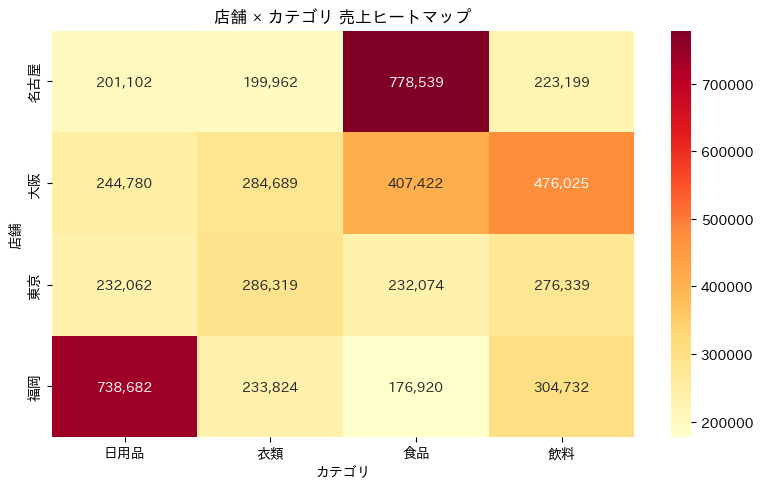

In [45]:
# ヒートマップで可視化
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=",.0f", cmap="YlOrRd")
plt.title("店舗 × カテゴリ 売上ヒートマップ")
plt.tight_layout()
plt.show()

### 📝 5章 練習問題

1. 店舗 × カテゴリ の客数の平均を示すピボットテーブルを作成しなさい。
2. 店舗 × 売上ランク のクロス集計表を作成し、割合（列方向）を求めなさい。
3. 作成したピボットテーブルをヒートマップで可視化しなさい。
4. `pivot_table` と `groupby` + `unstack` の違いを説明しなさい。

In [46]:
# 練習問題の解答欄



---
## 6. 時系列データの処理

日付・時刻データの操作とリサンプリングを学びます。

### 6.1 日付型への変換

In [47]:
# 日付型の確認
print(f"日付列の型: {sales_df['日付'].dtype}")

# 文字列から日付型への変換例
date_strings = ["2024/01/15", "2024/02/20", "2024/03/25"]
dates = pd.to_datetime(date_strings)
print(f"\n変換後: {dates}")

日付列の型: datetime64[ns]

変換後: DatetimeIndex(['2024-01-15', '2024-02-20', '2024-03-25'], dtype='datetime64[ns]', freq=None)


### 6.2 日付の成分を抽出

In [48]:
# dt アクセサで日付の成分を取得
sales_df["年"] = sales_df["日付"].dt.year
sales_df["月"] = sales_df["日付"].dt.month
sales_df["日"] = sales_df["日付"].dt.day
sales_df["曜日"] = sales_df["日付"].dt.day_name()  # 英語の曜日名
sales_df["曜日番号"] = sales_df["日付"].dt.dayofweek  # 0=月曜, 6=日曜

sales_df[["日付", "年", "月", "日", "曜日", "曜日番号"]].head()

,日付,年,月,日,曜日,曜日番号
0,2024-01-01,2024,1,1,Monday,0
1,2024-01-02,2024,1,2,Tuesday,1
2,2024-01-03,2024,1,3,Wednesday,2
3,2024-01-04,2024,1,4,Thursday,3
4,2024-01-05,2024,1,5,Friday,4


### 6.3 日付でフィルタリング

In [49]:
# 特定期間のデータを抽出
start_date = "2024-02-01"
end_date = "2024-02-29"

feb_data = sales_df[(sales_df["日付"] >= start_date) & (sales_df["日付"] <= end_date)]
print(f"2月のデータ: {len(feb_data)} 件")
feb_data.head()

2月のデータ: 29 件


,日付,店舗,カテゴリ,売上,客数,...,年,月,日,曜日,曜日番号
31,2024-02-01,東京,食品,40080.0,282.0,...,2024,2,1,Thursday,3
32,2024-02-02,福岡,食品,76842.0,148.0,...,2024,2,2,Friday,4
33,2024-02-03,大阪,食品,71373.0,196.0,...,2024,2,3,Saturday,5
34,2024-02-04,大阪,日用品,16776.0,NaN,...,2024,2,4,Sunday,6
35,2024-02-05,東京,食品,65016.0,257.0,...,2024,2,5,Monday,0


### 6.4 resample（リサンプリング）

In [50]:
# インデックスを日付に設定
ts_sales = sales_df.set_index("日付")
ts_sales.head()

,店舗,カテゴリ,売上,客数,店舗売上平均,...,年,月,日,曜日,曜日番号
日付,,,,,,,,,,,
2024-01-01,名古屋,日用品,60015.0,88.0,63763.727273,...,2024,1,1,Monday,0
2024-01-02,福岡,飲料,64268.0,131.0,53857.703704,...,2024,1,2,Tuesday,1
2024-01-03,東京,飲料,97939.0,153.0,54041.789474,...,2024,1,3,Wednesday,2
2024-01-04,名古屋,衣類,28141.0,NaN,63763.727273,...,2024,1,4,Thursday,3
2024-01-05,名古屋,飲料,90356.0,60.0,63763.727273,...,2024,1,5,Friday,4


In [51]:
# 週次に集計
weekly_sales = ts_sales[["売上", "客数"]].resample("W").sum()
print("週次売上:")
weekly_sales.head()

週次売上:


,売上,客数
日付,,
2024-01-07,488673.0,935.0
2024-01-14,468967.0,1411.0
2024-01-21,331122.0,951.0
2024-01-28,293618.0,1009.0
2024-02-04,270823.0,1189.0


In [52]:
# 月次に集計
monthly_sales = ts_sales[["売上", "客数"]].resample("ME").agg({
    "売上": "sum",
    "客数": "mean"
})
print("月次集計:")
monthly_sales

月次集計:


,売上,客数
日付,,
2024-01-31,1648132.0,167.896552
2024-02-29,1609679.0,187.740741
2024-03-31,1613576.0,187.933333
2024-04-30,425283.0,141.222222


### 6.5 移動平均と移動合計

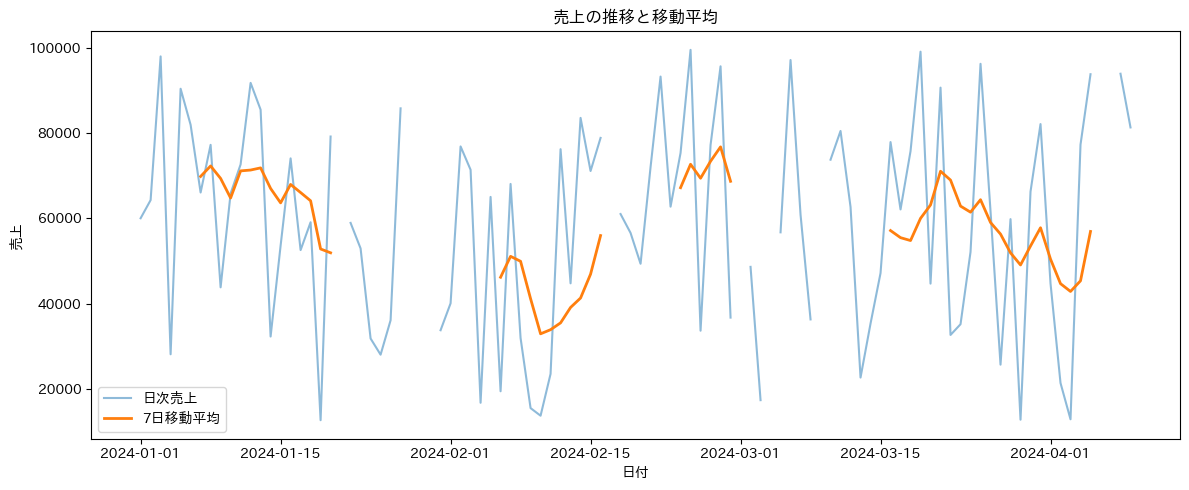

In [53]:
# 7日間の移動平均
ts_sales["売上_7日移動平均"] = ts_sales["売上"].rolling(window=7).mean()

# 可視化
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts_sales.index, ts_sales["売上"], alpha=0.5, label="日次売上")
ax.plot(ts_sales.index, ts_sales["売上_7日移動平均"], label="7日移動平均", linewidth=2)
ax.set_xlabel("日付")
ax.set_ylabel("売上")
ax.legend()
ax.set_title("売上の推移と移動平均")
plt.tight_layout()
plt.show()

### 📝 6章 練習問題

1. 曜日ごとの売上平均を計算し、どの曜日が最も売上が高いか調べなさい。
2. 週次の売上推移をグラフで可視化しなさい。
3. 14日間の移動合計を計算し、グラフで表示しなさい。
4. 月初と月末の売上を比較し、傾向を分析しなさい。

In [54]:
# 練習問題の解答欄



---
## 7. 文字列操作

pandas での文字列データの操作方法を学びます。

In [55]:
# サンプルデータ
str_df = pd.DataFrame({
    "名前": ["  山田 太郎  ", "佐藤花子", "SUZUKI Ichiro", "たなか けん"],
    "メール": ["yamada@example.com", "sato@EXAMPLE.COM", "suzuki@test.org", "tanaka@sample.jp"],
    "電話": ["03-1234-5678", "06-9876-5432", "052-111-2222", "092-333-4444"]
})
str_df

,名前,メール,電話
0,山田 太郎,yamada@example.com,03-1234-5678
1,佐藤花子,sato@EXAMPLE.COM,06-9876-5432
2,SUZUKI Ichiro,suzuki@test.org,052-111-2222
3,たなか けん,tanaka@sample.jp,092-333-4444


### 7.1 基本的な文字列操作（str アクセサ）

In [56]:
# 空白の除去
str_df["名前_trim"] = str_df["名前"].str.strip()

# 大文字・小文字変換
str_df["メール_lower"] = str_df["メール"].str.lower()
str_df["名前_upper"] = str_df["名前"].str.upper()

str_df[["名前", "名前_trim", "メール", "メール_lower"]]

,名前,名前_trim,メール,メール_lower
0,山田 太郎,山田 太郎,yamada@example.com,yamada@example.com
1,佐藤花子,佐藤花子,sato@EXAMPLE.COM,sato@example.com
2,SUZUKI Ichiro,SUZUKI Ichiro,suzuki@test.org,suzuki@test.org
3,たなか けん,たなか けん,tanaka@sample.jp,tanaka@sample.jp


### 7.2 文字列の検索と置換

In [57]:
# 特定の文字列を含むかチェック
str_df["example含む"] = str_df["メール"].str.lower().str.contains("example")
str_df[["メール", "example含む"]]

,メール,example含む
0,yamada@example.com,True
1,sato@EXAMPLE.COM,True
2,suzuki@test.org,False
3,tanaka@sample.jp,False


In [58]:
# 文字列の置換
str_df["電話_整形"] = str_df["電話"].str.replace("-", "")
str_df[["電話", "電話_整形"]]

,電話,電話_整形
0,03-1234-5678,0312345678
1,06-9876-5432,0698765432
2,052-111-2222,0521112222
3,092-333-4444,0923334444


### 7.3 文字列の分割と結合

In [59]:
# 文字列の分割
email_split = str_df["メール"].str.split("@", expand=True)
email_split.columns = ["ユーザー名", "ドメイン"]
email_split

,ユーザー名,ドメイン
0,yamada,example.com
1,sato,EXAMPLE.COM
2,suzuki,test.org
3,tanaka,sample.jp


In [60]:
# 正規表現で抽出
str_df["市外局番"] = str_df["電話"].str.extract(r"^(\d+)-")
str_df[["電話", "市外局番"]]

,電話,市外局番
0,03-1234-5678,03
1,06-9876-5432,06
2,052-111-2222,052
3,092-333-4444,092


### 📝 7章 練習問題

1. メールアドレスのドメイン部分だけを抽出した新しい列を作成しなさい。
2. 名前の文字数を数える列を追加しなさい（空白を除く）。
3. 電話番号の市外局番を使って、地域を分類する列を作成しなさい（03=東京, 06=大阪, 052=名古屋, 092=福岡）。

In [61]:
# 練習問題の解答欄



---
## 8. カテゴリカルデータの扱い

カテゴリ型データの効率的な扱い方を学びます。

### 8.1 カテゴリ型への変換

In [62]:
# カテゴリ型に変換
sales_df["店舗_cat"] = sales_df["店舗"].astype("category")

print(f"元の型: {sales_df['店舗'].dtype}")
print(f"カテゴリ型: {sales_df['店舗_cat'].dtype}")
print(f"\nカテゴリ: {sales_df['店舗_cat'].cat.categories.tolist()}")

元の型: object
カテゴリ型: category

カテゴリ: ['名古屋', '大阪', '東京', '福岡']


### 8.2 順序付きカテゴリ

In [63]:
# 会員ランクに順序を設定
rank_order = ["Bronze", "Silver", "Gold"]
customers_df["会員ランク_ord"] = pd.Categorical(
    customers_df["会員ランク"],
    categories=rank_order,
    ordered=True
)

# 順序でソート
customers_df.sort_values("会員ランク_ord")

,顧客ID,氏名,年齢,会員ランク,会員ランク_ord
3,C004,高橋美咲,23,Bronze,Bronze
1,C002,佐藤花子,35,Silver,Silver
4,C005,伊藤健太,31,Silver,Silver
0,C001,田中太郎,28,Gold,Gold
2,C003,鈴木一郎,42,Gold,Gold


### 8.3 カテゴリ型のメリット

In [64]:
# メモリ使用量の比較
print(f"文字列型のメモリ: {sales_df['店舗'].memory_usage(deep=True):,} bytes")
print(f"カテゴリ型のメモリ: {sales_df['店舗_cat'].memory_usage(deep=True):,} bytes")

文字列型のメモリ: 9,552 bytes
カテゴリ型のメモリ: 781 bytes


### 8.4 ダミー変数化（One-Hot Encoding）

In [65]:
# ダミー変数に変換（機械学習の前処理でよく使う）
dummies = pd.get_dummies(sales_df[["店舗", "カテゴリ"]], prefix=["店舗", "カテゴリ"])
dummies.head()

,店舗_名古屋,店舗_大阪,店舗_東京,店舗_福岡,カテゴリ_日用品,カテゴリ_衣類,カテゴリ_食品,カテゴリ_飲料
0,True,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False,True
2,False,False,True,False,False,False,False,True
3,True,False,False,False,False,True,False,False
4,True,False,False,False,False,False,False,True


### 📝 8章 練習問題

1. `sales_df` の「カテゴリ」列をカテゴリ型に変換しなさい。
2. 売上ランク（低・中・高）を順序付きカテゴリに変換し、ランク順に並べ替えなさい。
3. カテゴリ型を使うメリットとデメリットを説明しなさい。

In [66]:
# 練習問題の解答欄



---
## まとめ

このチュートリアルで学んだことをまとめます：

| トピック | 主なメソッド |
|---------|-------------|
| groupby 集計 | `groupby()`, `agg()`, `transform()` |
| 欠損値処理 | `isna()`, `dropna()`, `fillna()`, `interpolate()` |
| データ結合 | `merge()`, `concat()`, `join()` |
| データ変換 | `apply()`, `map()`, `cut()`, `qcut()` |
| ピボットテーブル | `pivot_table()`, `crosstab()` |
| 時系列処理 | `resample()`, `rolling()`, `dt` アクセサ |
| 文字列操作 | `str` アクセサ |
| カテゴリカルデータ | `astype('category')`, `pd.Categorical()`, `get_dummies()` |

## 次のステップ

これらの技術を組み合わせて、実際のデータ分析プロジェクトに挑戦しましょう！

---
## 総合演習

これまで学んだ内容を使って、以下の分析タスクに挑戦してください。

### 課題：売上データの総合分析

1. **データクリーニング**
   - 欠損値を適切な方法で処理しなさい
   - 必要に応じてデータ型を変換しなさい

2. **集計分析**
   - 店舗別・カテゴリ別の売上サマリーを作成しなさい
   - 曜日別の売上傾向を分析しなさい
   - 月次の売上推移を可視化しなさい

3. **顧客分析（orders_df と customers_df を使用）**
   - 会員ランク別の購入金額を分析しなさい
   - リピーター（複数回購入）を特定しなさい

4. **レポート作成**
   - 分析結果から得られた知見を 3 つ以上まとめなさい
   - ビジネスへの提言を考えなさい

In [67]:
# 総合演習の解答欄

